In [12]:
import torch
from torch import nn

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [48]:
hval = {}
    
def dhook(name):
    def inner_hook(grad):
        global hval
        hval[name] = grad
        return grad
    return inner_hook

def to_plot(tensor):
    return tensor.squeeze(1).T.detach().numpy()

def posteriorgram(data, xlab, ylab, title, **kwargs):
    sns.heatmap(data, cmap="YlGnBu", cbar=True, **kwargs)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.gca().invert_yaxis()

def double_posterior(dat, gradient, **kwargs):
    plt.figure(figsize=(18,14))
    plt.subplot(211)
    posteriorgram(dat, "Time", "Phones", "Activations", **kwargs)
    plt.subplot(212)
    posteriorgram(gradient, "Time", "Phones", "Gradient", **kwargs)

## CTC and Baum Welch

The Baum Welch procedure is the foundation of CTC, however CTC is more constrained. The two main constrains

1. The blank label - CTC mandates a label as the blank label in which the network doesn't make any predictions. This allows the network to be selective with it's predictions.
2. Constrained transition matrix - the CTC transition matrix is to either to stay in current phone, go blank or go to next voiced phone. (If prediction is blank, it stays blank or to next phone). Phones can be repeated, but you don't have branching paths, nor recursive transitions.

These are not well articulated (in fact Graves does not make any explicit links to Baum Welch) and are poorly justified. We will focus on part 2 since blank label investigations require real data for good intuition.

We refer to "Multi-path CTC" for the equations derived there. They have been verified to work within the pytorch framework of autograd. This is a huge result, as implementing CTC is non-trivial, and a version with custom transition matrices would be an incredible software engineering undertaking. 

In [126]:
def multi_ctc(ctc, data, targets, inlen, target_len):
    """
    For simplicity, we assume that the targets are equal length
    This is not necessary, but makes for slightly simpler code here
    """
    loss = 0
    for target in targets:
        l = ctc(data, target, inlen, target_len)
#         print(f"{l:.4f}:{np.exp(-l.item()):.4f} for {target}")
        loss += torch.exp(-l)
    totloss =  -torch.log(loss)
#     print(f"combo: {totloss}, {loss}")
    return totloss



In [129]:
def train_multi(data, targets, epochs=100):
    T, N, C = data.shape
    data = data.requires_grad_(True)
    # if we don't take sum, the CTCLoss will be
    # averaged across time and this means that our 
    # equation won't be correct since each path sum is kind of normalised
    ctcloss = nn.CTCLoss(reduction="sum")
    inlen = torch.IntTensor([T])
    target_len = torch.IntTensor([len(targets[0])])
    

    global hval
    hval = {}
    
    for epoch in range(epochs):
        data.register_hook(dhook("dgrad"))
        ds = data.log_softmax(2)
        ds.register_hook(dhook("ds"))
        loss = multi_ctc(ctcloss, ds, targets, inlen, target_len)
        loss.backward()
        # bootleg SGD
        data = data - .5 * hval["dgrad"]
    
    endp = data.softmax(2).squeeze(1).T.detach().numpy()
    grad = hval["ds"].squeeze(1).T.detach().numpy()
    return endp, grad
    

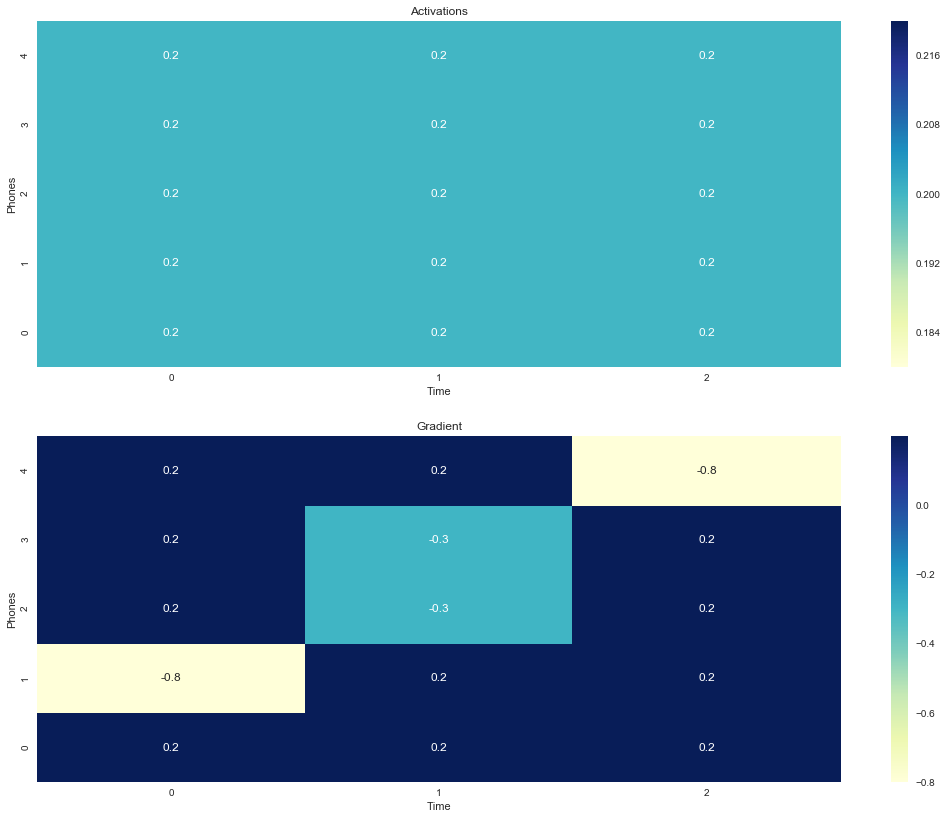

In [130]:
data = torch.zeros(3, 1, 5)
targets = [torch.IntTensor([1,3, 4]) , torch.IntTensor([1,2,4])]

end, g = train_multi(data, targets, 1)
double_posterior(to_plot(data.softmax(2)), g, annot=True)

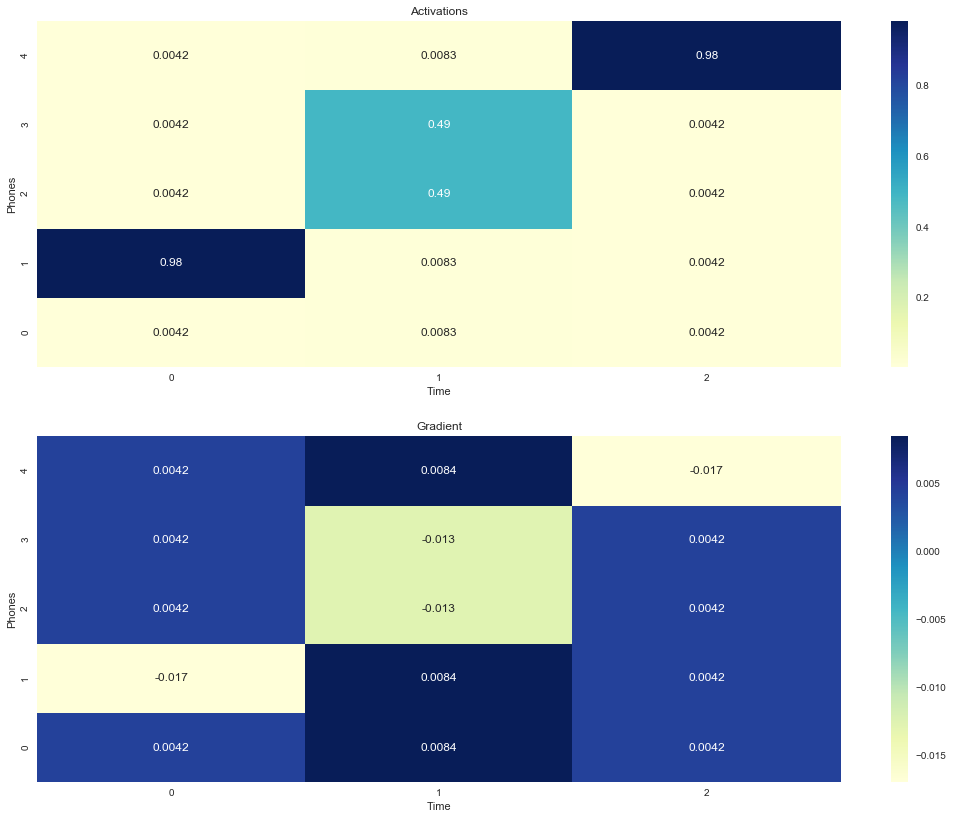

In [132]:
end, g = train_multi(data, targets, 100)
double_posterior(end, g, annot=True)

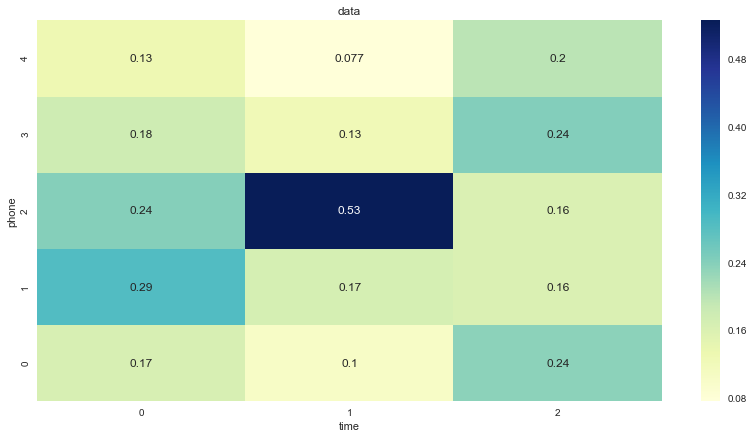

In [133]:
data_b = torch.rand(3, 1, 5)
# data_b[0,0,1] += 10
data_b[1,0,2] += 2
# data_b[2,0,4] += 10
targets = [torch.IntTensor([1,2, 4]), torch.IntTensor([1,3,4])]
plt.figure(figsize=(14,7))
posteriorgram(to_plot(data_b.softmax(2)), "time", "phone", "data", annot=True)

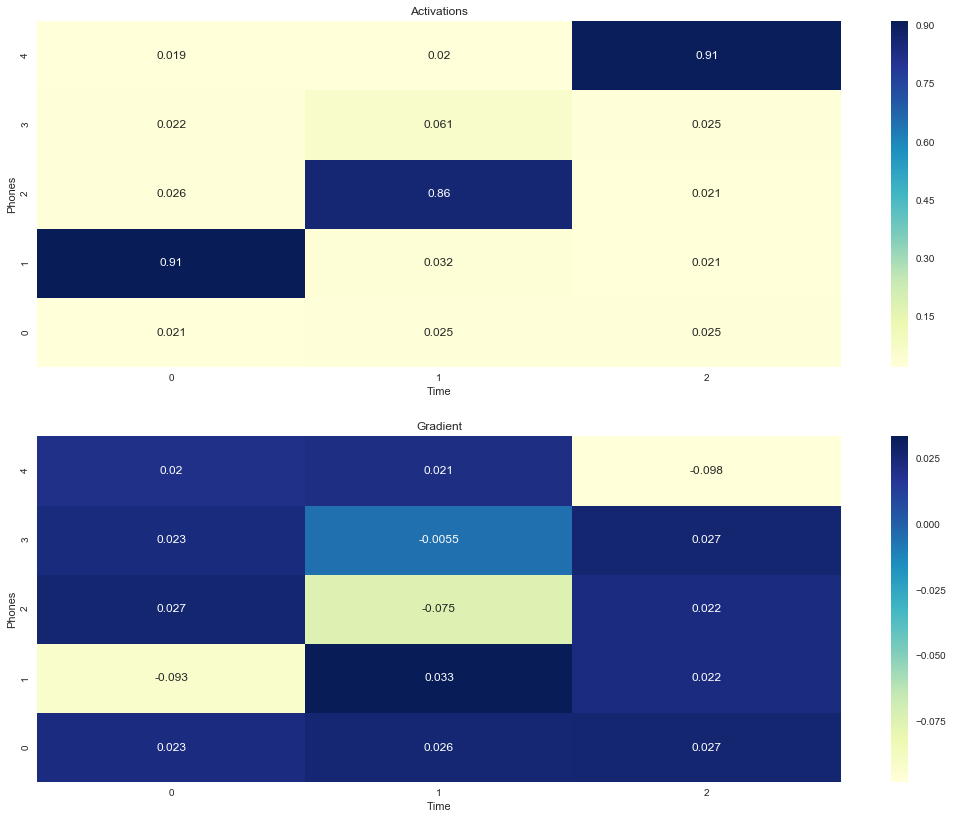

In [134]:
end, g = train_multi(data_b, targets, 20)
double_posterior(end, g, annot=True)

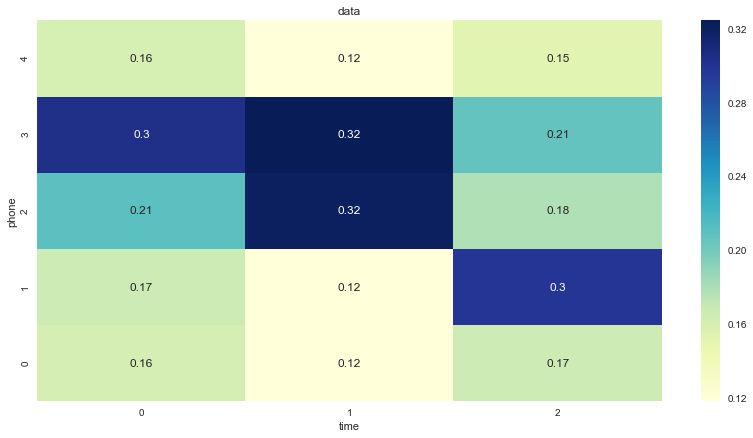

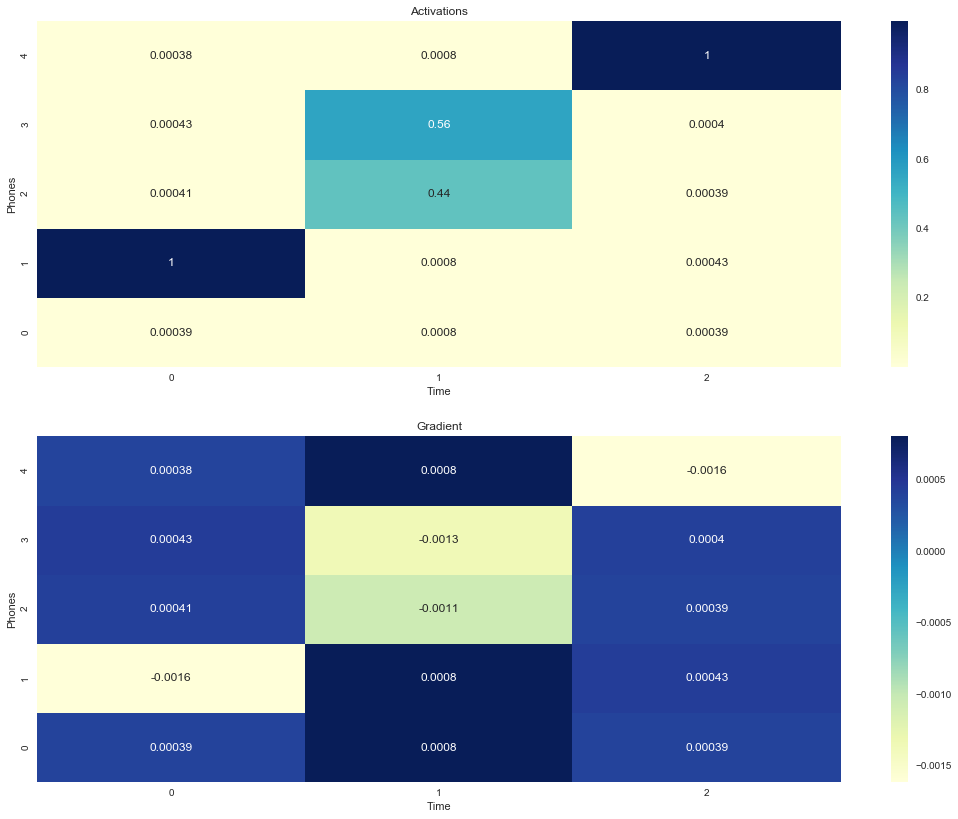

In [148]:
data_N = torch.rand(3, 1, 5)
data_N[1,0,:] = 0
data_N[1,0,2] = 1
data_N[1,0,3] = 1.01
# data_b[2,0,4] += 10
targets = [torch.IntTensor([1,2, 4]), torch.IntTensor([1,3,4])]

plt.figure(figsize=(18,7))
posteriorgram(to_plot(data_N.softmax(2)), "time", "phone", "data", annot=True)
end, g = train_multi(data_N, targets, 1000)
double_posterior(end, g, annot=True)

The above plots show that the multi-path CTC training that would be a natural extension from baum welch doesn't actually work very well here. Even from small starting differences, the eventual result is that the result is that the slightly more likely path becomes the overwhelming favourite. In contrast, values that are identical, remain so the entire way

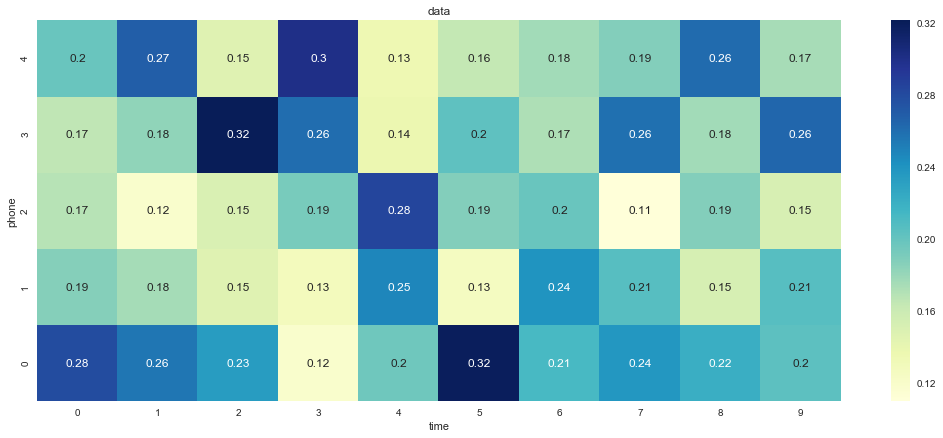

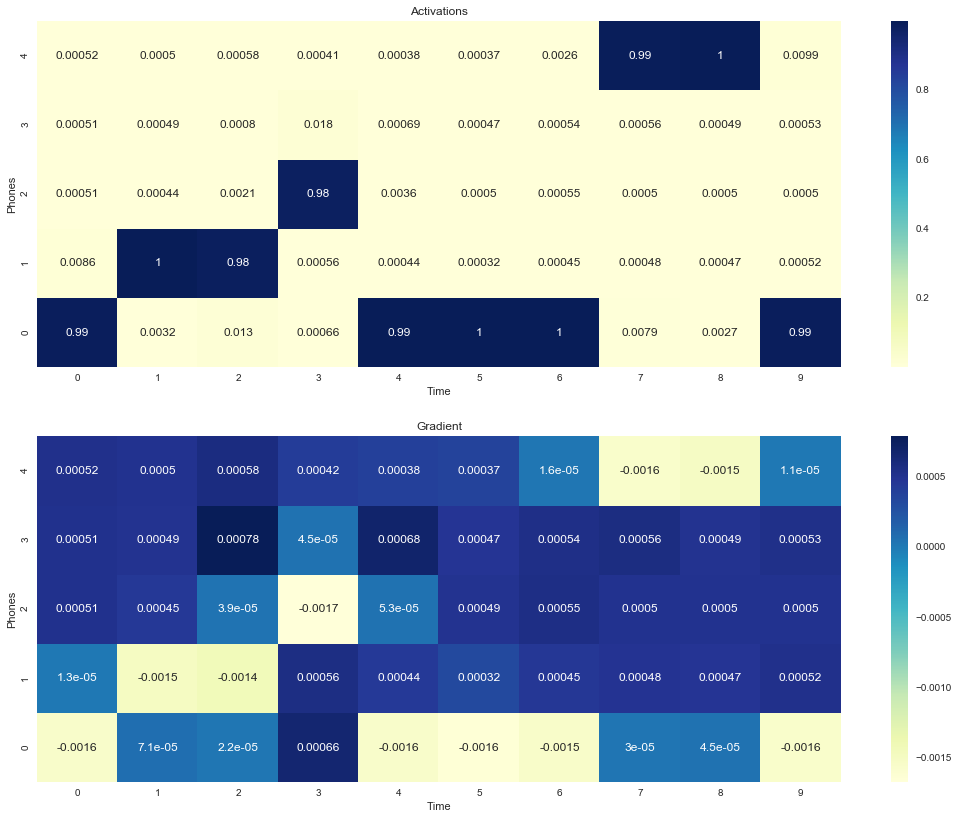

In [149]:
data_N = torch.rand(10, 1, 5)
# data_N[1,0,2] = 1
# data_N[1,0,3] = 1.1
# data_b[2,0,4] += 10
targets = [torch.IntTensor([1,2, 4]), torch.IntTensor([1,3,4])]

plt.figure(figsize=(18,7))
posteriorgram(to_plot(data_N.softmax(2)), "time", "phone", "data", annot=True)
end, g = train_multi(data_N, targets, 1000)
double_posterior(end, g, annot=True)

What does this mean when we have training data? This can be illustrated easily with a few thought experiments.

Consider the phones "ah" and "a". This is a common difference in pronounciation (tomato, alexa etc), so being able to learn the correct phone is useful. Let us assume we've done a curriculum learning, and our network is sort of good at picking these sounds. Now let us introduce branching paths.

1. The output of the a vs ah phone is close to 1, it’s that confident about the different phones. In this case, what will the gradients be? In this situation, since the gradients are weighted by likelihood, the correct path is identified and the gradients should be mostly 0. Hence, our network should be stable, but this is expected since it’s already converged on the correct phones - the fact that we are training isn’t helpful at this point.
2. What about a situation where the a vs ah sound is not so clear, say 0.7 for the correct phone and 0.3 for the wrong phone. In this case, each training example will make the correct pronunciation more correct. In the context of a batch, the gradients are now effectively weighted by the makeup of the pronunciations.
   
   - I.e. if the batch is evenly weighted 50-50 “ah” and ’a’ then the gradients effectively cancel the other out and again, we learn nothing between the phones in the batch. In this case, I believe we would eventually lose out ability to identify between ’a’ and ’ah’, always putting out 0.5, 0.5 for the phones (or would it just learn nothing in this case?)
   - If the batch is not evenly weighted. The pronunciation that is more common will dominate and our network will switch to predicting the more common pronunciation and the other phone would no longer be predicted at all.

The above results were seen in experimental tests. Training on Australian accents and then adding in a large number of American accent examples (large misbalance) resulted in our network shifting to always predicting american accents. 